In [1]:
import argopy
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from erddapy import ERDDAP
import datetime as dt
from PIL import Image

/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Lev_N/.pixi/envs/default/bin/python: No module named pip


In [2]:
# Get the ARGO data via ERDDAP (loop from 1997 to 2023)

sst_yrs = {}

for year in np.arange(2023,2024):
    print(year)
    e = ERDDAP(
        server="https://www.ifremer.fr/erddap",
        protocol="tabledap"
    )
    
    e.response = "csv"
    e.dataset_id = "ArgoFloats"
    e.constraints = {
        "time>=": f"{year}-01-01T00:00:00Z",
        "time<=": f"{year}-12-31T00:00:00Z",
        "latitude>=": 0,
        "latitude<=": 90,
        "longitude>=": -99,
        "longitude<=": 13,
    }
    e.variables = [
        "time", "latitude", "longitude", "temp", "pres"
    ]
    
    df = e.to_pandas()
    df = df.rename(columns={'time (UTC)': 'time',
           'latitude (degrees_north)': 'latitude',
           'longitude (degrees_east)': 'longitude',
           'temp (degree_Celsius)': 'temp',
           'pres (decibar)': 'pres'})
    sst = df[df.pres <= 10]
    sst.loc[:,'time'] = sst.time.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").date())
    sst = sst.drop(columns='pres')
    sst_yrs[str(year)] = sst.set_index('time')
    sst_yrs[str(year)].to_csv(f'../../data/argo_{year}.csv')

2023


KeyboardInterrupt: 

In [3]:
# Get the number of points per year
data_n = np.array([],dtype=np.int32)
for year in range(1997,2024):
    tmp = pd.read_csv(f'../../data/argo_{year}.csv').shape[0]
    data_n = np.append(data_n,tmp)

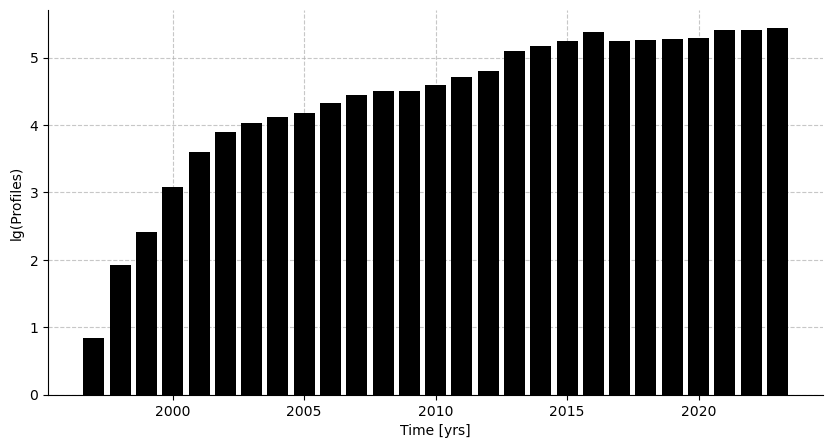

In [4]:
fig = plt.figure(figsize=(10,5))
plt.bar(np.arange(1997,2024),np.log10(data_n), color='black', zorder=2)
plt.xlabel('Time [yrs]')
plt.ylabel('lg(Profiles)')
plt.grid(ls='--', alpha=0.7, zorder=1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig(f'../../data/agro_sampling_temporal.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
#get distribution per years
dsts = []
for year in range(1997,2024):
    tmp = pd.read_csv(f'../../data/argo_{year}.csv')
    tmp.loc[:,'time'] = pd.to_datetime(tmp.time).apply(lambda x: x.year)
    dsts.append(tmp)

In [6]:
dsts_full = pd.concat(dsts, axis=0, ignore_index=True)

In [7]:
dsts_full.head()

,time,latitude,longitude,temp
0,1997,0.236,-19.688,22.751
1,1997,0.054,-20.390,24.416
2,1997,0.483,-22.395,25.912
3,1997,0.017,-23.218,26.449
4,1997,0.670,-24.427,27.230


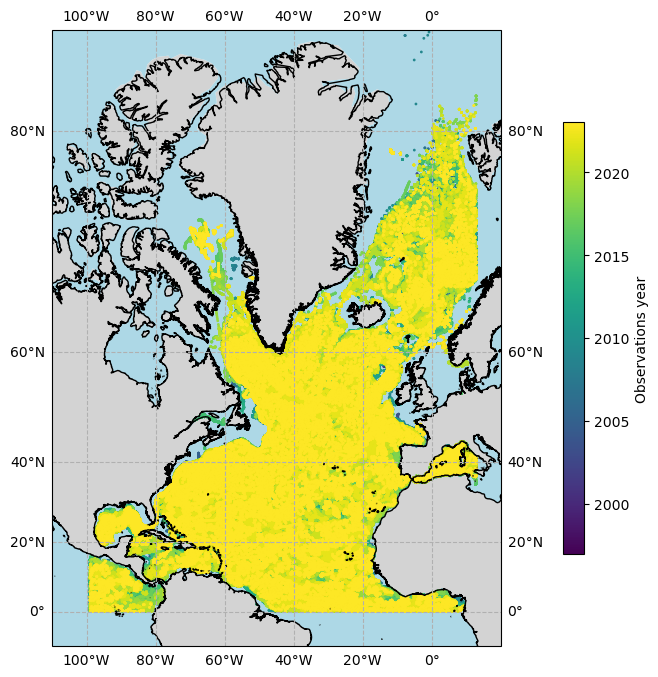

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Mercator projection
projection = ccrs.Mercator()

# Define the figure and add a subplot with the Mercator projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Set the extent to the North Atlantic region (longitude and latitude)
ax.set_extent([-110, 20, -10, 90], crs=ccrs.PlateCarree())

# Add coastlines and land features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot scatter points on the map
scatter = ax.scatter(dsts_full.longitude, dsts_full.latitude, c=dsts_full.time, s=1, cmap='viridis', transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7, pad=0.08)
cbar.set_label('Observations year')  # Set the label for the color bar

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, ls='--')

# Show the plot
#plt.savefig(f'../../data/agro_sampling_year_distribution.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
#Animation plots to check the distribtuion of ARGO floats
# Create a Mercator projection
for year in range(1997,2024):
    projection = ccrs.Mercator()
    
    # Define the figure and add a subplot with the Mercator projection
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
    
    # Set the extent to the North Atlantic region (longitude and latitude)
    ax.set_extent([-110, 20, -10, 90], crs=ccrs.PlateCarree())
    
    # Add coastlines and land features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    
    # Plot scatter points on the map
    scatter = ax.scatter(dsts_full[dsts_full.time == year].longitude, 
                         dsts_full[dsts_full.time == year].latitude, 
                         c=dsts_full[dsts_full.time == year].temp, 
                         s=1,
                         cmap='viridis',
                         transform=ccrs.PlateCarree(), vmin=0, vmax=35)
    
    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, ls='--')
    
    ax.set_title(f'Year: {year}')

    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7, pad=0.08, ticks = np.arange(0,35,5))
    cbar.set_label('SST [°C]')  # Set the label for the color bar
    
    # Show the plot
    #plt.savefig(f'../../maps_animation/map_{year}.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
    plt.close()

In [17]:
import imageio

# List of image file paths (replace with your actual file paths)
output_gif = "temp_scatter.gif"
image_paths = [f"../../maps_animation/map_{year}.jpeg" for year in range(1997,2024)]

# Set the FPS (frames per second)
fps = 2  # This means each image will be shown for 0.5 seconds (1/fps)

# Read images and create GIF
#images = [imageio.imread(image_path) for image_path in image_paths]
#imageio.mimsave(output_gif, images, fps=fps)

# Set the desired dimensions
width, height = 1200, 1200

# Read, resize, and convert images to RGB
images = []
for img_path in image_paths:
    img = Image.open(img_path)
    img = img.resize((width, height))  # Resize to the same dimensions
    img = img.convert("RGB")           # Convert to RGB mode
    images.append(np.array(img))       # Convert to numpy array

# Create and save the GIF
#imageio.mimsave(output_gif, images, fps=2)

In [8]:
#average data annually
na_sst_annual, months_in_averaging = {},{}
for year in range(1997,2024):
    tmp = pd.read_csv(f'../../data/argo_{year}.csv')
    tmp.loc[:,'months'] = pd.to_datetime(tmp.time).apply(lambda x: x.month)
    months_in_averaging[str(year)] = np.unique(tmp.months)
    tmp = tmp.drop(columns=['time', 'months'])
    tmp = tmp.groupby(by=['longitude','latitude']).agg('mean')
    na_sst_annual[str(year)] = tmp

In [34]:
#Animation plots to check the distribtuion of ARGO floats (annual averages)
# Create a Mercator projection
for year in range(1997,2024):
    projection = ccrs.Mercator()
    
    # Define the figure and add a subplot with the Mercator projection
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})
    
    # Set the extent to the North Atlantic region (longitude and latitude)
    ax.set_extent([-110, 20, -10, 90], crs=ccrs.PlateCarree())
    
    # Add coastlines and land features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    
    # Plot scatter points on the map
    scatter = ax.scatter(na_sst_annual[str(year)].reset_index().longitude, 
                         na_sst_annual[str(year)].reset_index().latitude, 
                         c=na_sst_annual[str(year)].temp, 
                         s=1,
                         cmap='viridis',
                         transform=ccrs.PlateCarree(), vmin=0, vmax=35)
    
    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, ls='--')
    
    ax.set_title(f'Year: {year}')

    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7, pad=0.08, ticks = np.arange(0,35,5))
    cbar.set_label('SST [°C]')  # Set the label for the color bar
    
    # Show the plot
    #plt.savefig(f'../../maps_animation/sst_{year}_averaged.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
    plt.close()

In [35]:
import imageio

# List of image file paths (replace with your actual file paths)
output_gif = "temp_scatter_annual_averages.gif"
image_paths = [f"../../maps_animation/sst_{year}_averaged.jpeg" for year in range(1997,2024)]

# Set the FPS (frames per second)
fps = 2  # This means each image will be shown for 0.5 seconds (1/fps)

# Read images and create GIF
#images = [imageio.imread(image_path) for image_path in image_paths]
#imageio.mimsave(output_gif, images, fps=fps)

# Set the desired dimensions
width, height = 1200, 1200

# Read, resize, and convert images to RGB
images = []
for img_path in image_paths:
    img = Image.open(img_path)
    img = img.resize((width, height))  # Resize to the same dimensions
    img = img.convert("RGB")           # Convert to RGB mode
    images.append(np.array(img))       # Convert to numpy array

# Create and save the GIF
#imageio.mimsave(output_gif, images, fps=2)

In [9]:
# resconstruct ERSST grid
sat_lon = np.arange(-98,12,2)
sat_lat = np.arange(-2,90,2)

na_sst_annual_combined = []

# prepare pandas dataset
for year in range(1997,2024):
    tmp = na_sst_annual[str(year)].reset_index()
    tmp.loc[:,'time'] = np.full(tmp.shape[0], year)
    na_sst_annual_combined.append(tmp)

na_sst_annual_combined = pd.concat(na_sst_annual_combined, axis=0, ignore_index=True)

In [10]:
na_sst_annual_combined.loc[:,'sat_lon'] = na_sst_annual_combined.longitude.apply(lambda x: sat_lon[np.where(np.abs(x - sat_lon).min() == (np.abs(x - sat_lon)))[0][0]])
na_sst_annual_combined.loc[:,'sat_lat'] = na_sst_annual_combined.latitude.apply(lambda x: sat_lat[np.where(np.abs(x - sat_lat).min() == (np.abs(x - sat_lat)))[0][0]])

In [11]:
na_sst_sat_interpolated = na_sst_annual_combined.copy()
na_sst_sat_interpolated = na_sst_sat_interpolated.drop(columns= ['longitude', 'latitude'])

In [12]:
na_sst_sat_interpolated = na_sst_sat_interpolated.groupby(by=['time', 'sat_lat', 'sat_lon']).agg('mean').to_xarray()

In [13]:
#trying to calcualate AMV
sst_anomaly = na_sst_sat_interpolated.sel(time=slice(2001,None)) - na_sst_sat_interpolated.sel(time=slice(2001,None)).mean(dim=['time'])
mean_na_sst = na_sst_sat_interpolated.sel(time=slice(2001,None)).mean(dim=['sat_lat', 'sat_lon'])
#detrend


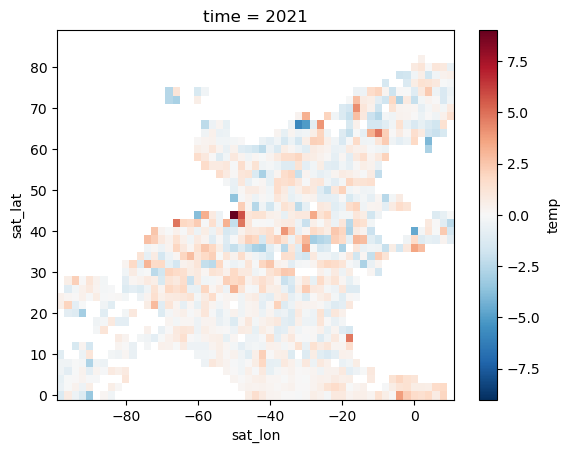

In [29]:
sst_anomaly.isel(time=20).temp.plot()

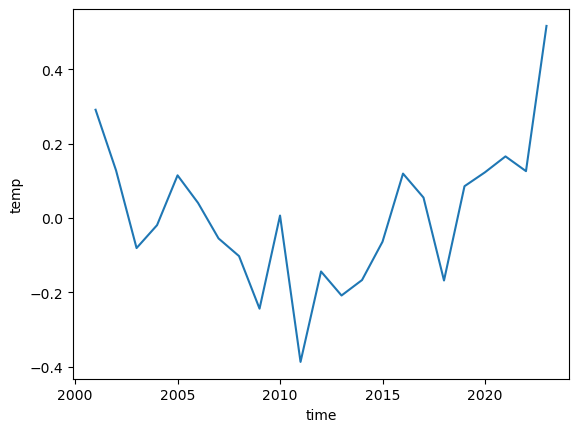

In [18]:
sst_anomaly.mean(dim=['sat_lat', 'sat_lon']).temp.plot()

In [36]:
slope,intercept = np.polyfit(np.arange(1,mean_na_sst.temp.shape[0]+1),mean_na_sst.temp,1)
trend = slope*np.arange(1,mean_na_sst.temp.shape[0]+1) + intercept

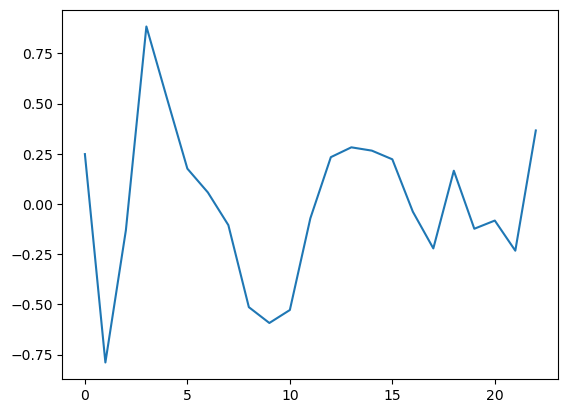

In [39]:
plt.plot(mean_na_sst.temp - trend)


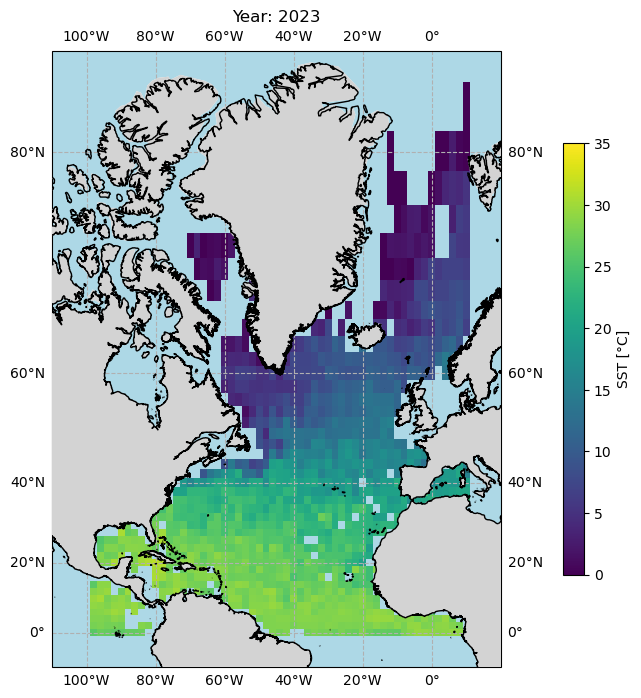

In [159]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Mercator projection
projection = ccrs.Mercator()

# Define the figure and add a subplot with the Mercator projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Set the extent to the North Atlantic region (longitude and latitude)
ax.set_extent([-110, 20, -10, 90], crs=ccrs.PlateCarree())

# Plot scatter points on the map
scatter = ax.pcolormesh(na_sst_sat_interpolated.sel(time=2023).sat_lon, 
                     na_sst_sat_interpolated.sel(time=2023).sat_lat, 
                     na_sst_sat_interpolated.sel(time=2023).temp, 
                     cmap='viridis', transform=ccrs.PlateCarree(),zorder=2, 
                     vmin=0, vmax=35)

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.7, pad=0.08)
cbar.set_label('SST [°C]')  # Set the label for the color bar

# Add coastlines and land features
ax.coastlines(resolution='10m',zorder=4)
ax.add_feature(cfeature.LAND, facecolor='lightgray',zorder=3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue',zorder=1)

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, ls='--')

ax.set_title(f'Year: 2023')

# Show the plot
#plt.savefig(f'../../data/agro_interpolated.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
plt.show()

## Comparing with ERSST

In [143]:
sat_data = xr.open_dataset('../../data/sst_north_atlantic.nc')

In [144]:
sat_data_short = sat_data.sel(time=slice(dt.date(2001,1,1),dt.date(2023,12,31)))

In [145]:
sat_data_short = sat_data_short.resample(time='YE').mean()

In [146]:
sat_data_short_mean = sat_data_short.mean(dim=['time'])
sat_data_short_anomaly = sat_data_short - sat_data_short_mean

In [147]:
sst_anomaly['time'] = sat_data_short_anomaly.time

In [148]:
na_sst_anomaly_ersst = sat_data_short_anomaly.mean(dim=['lat','lon']).sst
na_sst_anomaly_argo = sst_anomaly.mean(dim=['sat_lat', 'sat_lon']).temp

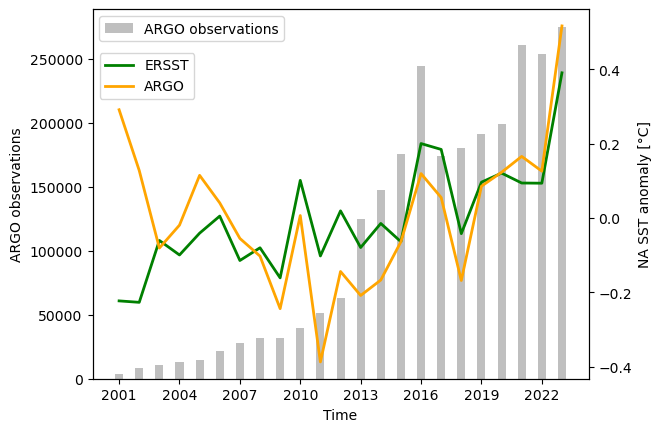

In [149]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the bar chart
ax1.bar(np.arange(2001,2024), data_n[4:], color='grey', label='ARGO observations', width=0.4, alpha=0.5)

# Create a second y-axis for the line plot
ax2 = ax1.twinx()

# Plot the line chart
ax2.plot(np.arange(2001,2024), na_sst_anomaly_ersst, color='green', label='ERSST', lw=2.)
ax2.plot(np.arange(2001,2024), na_sst_anomaly_argo, color='orange', label='ARGO', lw=2.)

# Add labels, title, and legend
ax1.set_xlabel('Time')
ax1.set_ylabel('ARGO observations')
ax2.set_ylabel('NA SST anomaly [°C]')

ax1.set_xticks(np.arange(2001,2024,3))

# Show legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0.0005, 0.9))

plt.show()

In [150]:
cor1 = xr.corr(na_sst_anomaly_ersst.isel(time=slice(None,13)), na_sst_anomaly_argo.isel(time=slice(None,13)))
cor2 = xr.corr(na_sst_anomaly_ersst.isel(time=slice(13,None)), na_sst_anomaly_argo.isel(time=slice(13,None)))

In [151]:
cor1.data, cor2.data

(array(-0.19223609), array(0.91045028))

In [152]:
rmse1 = np.sqrt(((na_sst_anomaly_ersst.isel(time=slice(None,13)) - na_sst_anomaly_argo.isel(time=slice(None,13)))**2).mean())
rmse2 = np.sqrt(((na_sst_anomaly_ersst.isel(time=slice(13,None)) - na_sst_anomaly_argo.isel(time=slice(13,None)))**2).mean())

In [153]:
rmse1.data, rmse2.data

(array(0.20851586), array(0.09184311))

In [140]:
# estimating spacial difference
sat_data_short_anomaly['lat'] = sst_anomaly.sat_lat
sat_data_short_anomaly['lon'] = sst_anomaly.sat_lon

diff = sst_anomaly.temp - sat_data_short_anomaly.sst

In [160]:
na_sst_sat_interpolated_short = na_sst_sat_interpolated.sel(time=slice(2001,2023))

In [162]:
na_sst_sat_interpolated_short['time'] = sat_data_short.time

In [163]:
sat_data_short = sat_data_short.interp({'lat': na_sst_sat_interpolated_short.sat_lat, 
                                        'lon': na_sst_sat_interpolated_short.sat_lon})

In [174]:
argo_ersst_dif = na_sst_sat_interpolated_short.temp - sat_data_short.sst

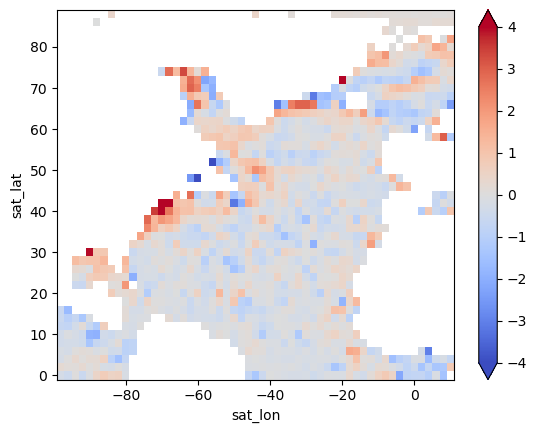

In [180]:
argo_ersst_dif.mean(dim='time').plot(vmin=-4,vmax=4, cmap='coolwarm')

In [181]:
argo_ersst_dif.mean()

<xarray.DataArray ()> Size: 8B
array(-0.01699386)

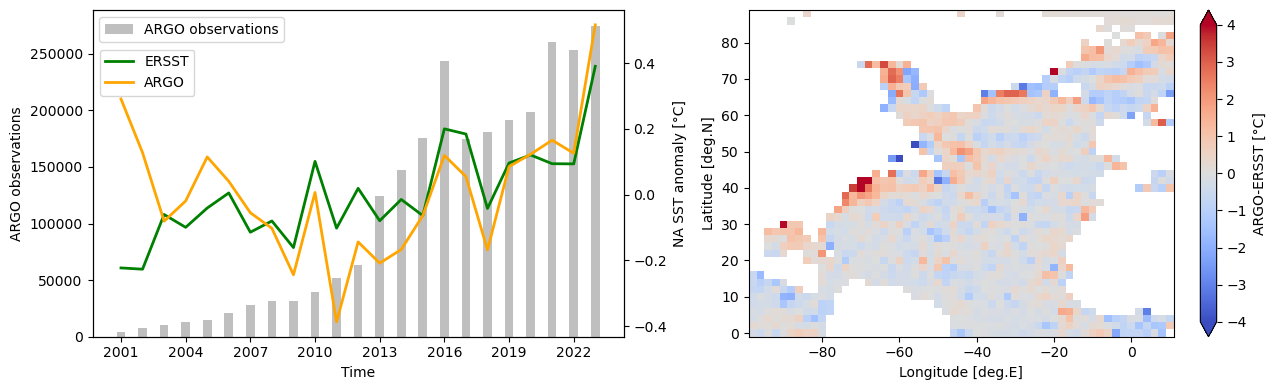

In [197]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1,2, figsize=(13,4))

# Plot the bar chart
ax[0].bar(np.arange(2001,2024), data_n[4:], color='grey', label='ARGO observations', width=0.4, alpha=0.5)

# Create a second y-axis for the line plot
ax2 = ax[0].twinx()

# Plot the line chart
ax2.plot(np.arange(2001,2024), na_sst_anomaly_ersst, color='green', label='ERSST', lw=2.)
ax2.plot(np.arange(2001,2024), na_sst_anomaly_argo, color='orange', label='ARGO', lw=2.)

# Add labels, title, and legend
ax[0].set_xlabel('Time')
ax[0].set_ylabel('ARGO observations')
ax2.set_ylabel('NA SST anomaly [°C]')

ax[0].set_xticks(np.arange(2001,2024,3))

# Show legend for both plots
ax[0].legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0.0005, 0.9))


xr_plt = argo_ersst_dif.mean(dim='time').plot(vmin=-4,vmax=4, cmap='coolwarm', ax=ax[1])
ax[1].set_xlabel('Longitude [deg.E]')
ax[1].set_ylabel('Latitude [deg.N]')
xr_plt.colorbar.set_label('ARGO-ERSST [°C]')


plt.tight_layout()
#plt.savefig(f'../../data/diff_analysis.jpeg', format='jpeg', bbox_inches='tight', dpi=300)
plt.show()